In [ ]:
import pandas as pd
import numpy as np
import joblib
from tqdm.notebook import tqdm
import pickle
import random
from collections import Counter
import json
from FlagEmbedding import FlagModel
from glob import glob
from unicodedata import normalize
from nltk.tokenize import word_tokenize
from os import path
import os
import shutil
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

In [5]:
sns.set_context("talk")
sns.set_theme(style='white')
sns.set_style("whitegrid")
sns.set_palette('bright')

In [2]:
model = FlagModel('crazyjeannot/fr_literary_bge_base',
                  query_instruction_for_retrieval="",
                  use_fp16=True) 

In [3]:
model = FlagModel('BAAI/bge-m3',
                  query_instruction_for_retrieval="",
                  use_fp16=True) 

/usr/local/lib/python3.9/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
def calculate_cosine_distance(df):
    embedding_vectors = df.values
    cosine_similarity_matrix = cosine_similarity(embedding_vectors)
    cosine_distance_matrix = cosine_similarity_matrix
    cosine_distance_df = pd.DataFrame(cosine_distance_matrix, index=df.index, columns=df.index)
    return cosine_distance_df

In [7]:
def clean_text(txt):
    txt_res = normalize("NFKD", txt).replace('\xa0', ' ')
    txt_res = txt_res.replace("\\", "").replace('\\xa0', '')
    return txt_res

In [11]:
def get_embeddings(path_name, N_tirages=500, M_words_per_passages=512):
    index_tmp, sentences_tmp, novels_tmp = [], [], []
    for doc in tqdm(glob(path_name)):
        
        doc_name = path.splitext(path.basename(doc))[0]
        #print(doc_name)
        with open(doc, encoding="utf8") as file:
            text = str(file.read()).lower()
            text_clean = clean_text(text) # enleve les accents
            text_clean = re.sub(r'[^\w\s]', '', text_clean)  # garde seulement les suites de caractère

        current_words = [word for word in word_tokenize(text_clean)]
        
        passages_indices = [random.randint(0, len(current_words) - (M_words_per_passages+1)) for _ in range(N_tirages)]
            # passages is list of N str (and str is joined M sentences)
        passages = [" ".join(current_words[indice:indice+M_words_per_passages]) for indice in passages_indices]
        
        index_passages = [doc_name+"_passage-"+str(j)+"_sentence-"+str(passages_indices[j]) for j in range(N_tirages)]

        sentences_tmp += passages
        index_tmp += index_passages

        #index_romans = ['_'.join(doc_name.split("_")[:-1]) for _ in range(N_tirages)]
        novels_tmp += [doc_name for _ in range(N_tirages)]
        
    print(len(sentences_tmp), len(index_tmp))
    print("GET PASSAGES OK")
    embeddings_raw = model.encode(sentences_tmp, # list of str
                            #batch_size=12, 
                            #max_length=512,#8192,#512
                            )#['dense_vecs']#['dense_vecs']
    embeddings = [elem.tolist() for elem in embeddings_raw]
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)
    
    df_tmp = pd.DataFrame({'novel_name': novels_tmp, 'index_name': index_tmp, 'embeddings': scaled_embeddings.tolist()})        
    df_tmp['embeddings'] = df_tmp['embeddings'].apply(np.array)
    
    #embedding_tmp = pd.DataFrame(embeddings, columns=[f'dim_{i}' for i in range(1024)])
    #print(embedding_tmp)
    num_dimensions = len(embeddings[0])
    embedding_columns_tmp = pd.DataFrame(df_tmp['embeddings'].tolist(), columns=[f'dim_{i}' for i in range(num_dimensions)])

    #df_normalized = normalize_vectors_z_score(embedding_columns_tmp)#normalize_vectors_z_score, normalize_vectors
    #df_normalized["index_name"] = df_normalized.index
    #df_tmp['embeddings'] = df_normalized.values.tolist()
    df_tmp['embeddings'] = embedding_columns_tmp.values.tolist()
    df_tmp['embeddings'] = df_tmp['embeddings'].apply(np.array)
    
    #return df_tmp
    mean_embeddings = df_tmp.groupby('novel_name')['embeddings'].mean()
    unique_novel_names = list(df_tmp.groupby('novel_name').groups.keys())

    mean_embeddings_list = mean_embeddings.tolist()    
    df_mean_embeddings = pd.DataFrame({'novel_name': unique_novel_names, 'mean_embeddings': mean_embeddings_list})

    num_dimensions = len(mean_embeddings_list[0])
    embedding_columns = pd.DataFrame(df_mean_embeddings['mean_embeddings'].tolist(), columns=[f'dim_{i}' for i in range(num_dimensions)])
    df_mean_embeddings_final = pd.concat([df_mean_embeddings['novel_name'], embedding_columns], axis=1)

    return df_mean_embeddings_final

In [12]:
def get_most_similar(df, novel_name, top_n=5):
    # Get the row corresponding to the novel_name
    row = df.loc[novel_name]
    # Sort the row in descending order and get the top_n indices
    most_similar = row.sort_values(ascending=False)[:top_n].index.tolist()
    return most_similar

In [13]:
def sanity_check(df, topN=5):
    good_accuracy, len_test = 0, 0

    for novel_name in df.index:
        most_similar = get_most_similar(df, novel_name, topN)
        most_similar_racine = ['_'.join(elem.split('_')[:-1]) if len(elem.split('_'))>4 else elem for elem in most_similar]
        roman_racine_courant = '_'.join(novel_name.split('_')[:-1]) if len(novel_name.split('_'))>4 else novel_name
            
        for novel_racine_similar in most_similar_racine:
            len_test += 1
            if novel_racine_similar == roman_racine_courant:
                good_accuracy += 1
                #print(novel_name)
    print(good_accuracy, len_test)
    print(good_accuracy/len_test)

    return good_accuracy/len_test 


## SANITY CHECK - N=1000

In [ ]:
TIRAGES = [100, 50, 20, 10, 5, 4, 3, 2, 1]
TIRAGES_reversed = TIRAGES[::-1]
results_list = []

for tirage in TIRAGES_reversed:
    print(f"Processing N_tirages={tirage}...")
    
    # Step 1: Get embeddings with the current tirage value
    embeddings = get_embeddings("/data/jbarre/selected_gallica_1000/*.txt", N_tirages=tirage)
    
    # Step 2: Set the index
    embeddings.set_index(["novel_name"], inplace=True)
    
    # Step 3: Calculate cosine distance
    cosine_distance = calculate_cosine_distance(embeddings)
    
    # Step 4: Run the sanity check
    res = sanity_check(cosine_distance, 5)
    
    # Step 5: Store the result in the list
    results_list.append(res)
    print(results_list)

Processing N_tirages=5...


  0%|          | 0/5000 [00:00<?, ?it/s]

25000 25000
GET PASSAGES OK


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [03:05<00:00,  1.89s/it]


21999 25000
0.87996
[0.87996]
Processing N_tirages=10...


  0%|          | 0/5000 [00:00<?, ?it/s]

50000 50000
GET PASSAGES OK


Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [05:44<00:00,  1.76s/it]


24031 25000
0.96124
[0.87996, 0.96124]
Processing N_tirages=20...


  0%|          | 0/5000 [00:00<?, ?it/s]

100000 100000
GET PASSAGES OK


Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [11:32<00:00,  1.77s/it]


24696 25000
0.98784
[0.87996, 0.96124, 0.98784]
Processing N_tirages=50...


  0%|          | 0/5000 [00:00<?, ?it/s]

250000 250000
GET PASSAGES OK


Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 977/977 [28:58<00:00,  1.78s/it]


24905 25000
0.9962
[0.87996, 0.96124, 0.98784, 0.9962]
Processing N_tirages=100...


  0%|          | 0/5000 [00:00<?, ?it/s]

In [3]:
TIRAGES = [1, 2, 3, 4, 5, 10, 20, 50, 100]
BGE_M3 = [0.35476, 0.53984, 0.68088, 0.76912, 0.8282, 0.95072, 0.98508, 0.99544, 1.0]
FR_LITERARY_BGE = [0.44952, 0.64204, 0.7664, 0.84132, 0.88784, 0.96952, 0.99196, 1.0, 1.0]

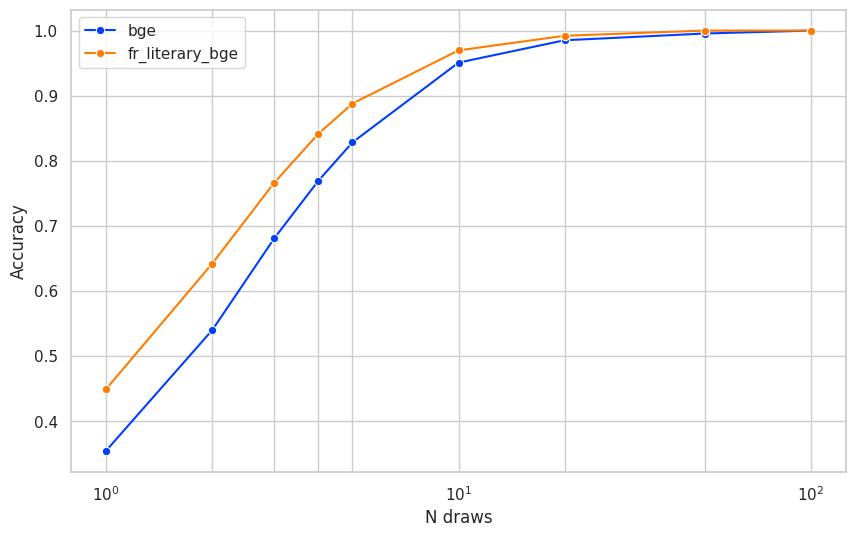

In [6]:
# Create a seaborn scatter plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=TIRAGES, y=BGE_M3, marker='o', label="bge")
sns.lineplot(x=TIRAGES, y=FR_LITERARY_BGE, marker='o', label="fr_literary_bge")
plt.xscale('log')
plt.xticks(ticks=TIRAGES)
# Set the labels and title
plt.xlabel("N draws")
plt.ylabel("Accuracy")

# Save the figure as a PNG file
plt.savefig('TIRAGES_RESULT.png', format='png', bbox_inches='tight', dpi=400)

# Show the plot
plt.show()